In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.scan_helper_functions import load_dataset, calculate_metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [4]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [5]:
version = '0'

In [6]:
datafile = directory +'/aerosol_data/phase_data_noise_small.hdf5'

In [7]:
model_name = 'autoencoder_noise_small'+version


In [8]:
model_dir = directory +'/aerosol_results/models_phase/autoencoder/'+model_name
model_dir

'/data/user/boiger_r/aerosol/aerosol_results/models_phase/autoencoder/autoencoder_noise_small0'

In [9]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir+'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [10]:
plot_dir

'/data/user/boiger_r/aerosol/aerosol_results/models_phase/autoencoder/autoencoder_noise_small0/plots/model'

# Load the model and the data

In [11]:
autoencoder = keras.models.load_model(model_dir)
autoencoder

In [12]:
dir(autoencoder)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [13]:
dvar = pd.read_hdf(datafile,key='dvar')
qoi = pd.read_hdf(datafile,key='qoi')
dvar_train, dvar_val, dvar_test, qoi_train, qoi_val, qoi_test = load_dataset(datafile)
dvar_train.T[2] = dvar_train.T[2]*1.e+08
dvar_val.T[2] = dvar_val.T[2]*1.e+08
dvar_test = np.array(dvar_test)
dvar_test.T[2] =dvar_test.T[2]*1.e+08 
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

qoi_train = min_max_scaler.fit_transform(qoi_train)
qoi_val = min_max_scaler.fit_transform(qoi_val)
qoi_test = min_max_scaler.fit_transform(qoi_test)

In [13]:
dvar_test

array([[1.00000000e-01, 1.70000000e+00, 1.00000000e+00, 1.51000000e+00,
        1.99053585e-02],
       [1.90000000e+00, 1.60000000e+00, 1.00000000e+00, 1.45000000e+00,
        7.92446596e-03],
       [1.90000000e+00, 1.20000000e+00, 1.00000000e+00, 1.51000000e+00,
        3.15478672e-01],
       ...,
       [1.10000000e+00, 1.70000000e+00, 1.00000000e+00, 1.39000000e+00,
        3.15478672e-03],
       [2.10000000e+00, 1.70000000e+00, 1.00000000e+00, 1.59000000e+00,
        1.25594322e-03],
       [1.30000000e+00, 1.80000000e+00, 1.00000000e+00, 1.56000000e+00,
        7.92446596e-04]])

In [14]:
train_data = [dvar_train,qoi_train]
val_data = [dvar_val,qoi_val]
test_data = [dvar_test,qoi_test]

In [15]:
test_data[1]

array([[0.29392627, 0.29713632, 0.31712905, ..., 0.17178535, 0.17496704,
        0.17398597],
       [0.98408717, 0.96436993, 0.96830142, ..., 0.77580806, 0.76380009,
        0.7314525 ],
       [0.96945329, 0.97854098, 0.97943356, ..., 0.53668252, 0.53194446,
        0.51909781],
       ...,
       [0.89735028, 0.89597357, 0.91201161, ..., 0.73618835, 0.71381188,
        0.69883242],
       [0.98813207, 0.97906398, 0.96732812, ..., 0.97676978, 0.96864723,
        0.95842103],
       [0.93239343, 0.92677362, 0.93092818, ..., 0.88899734, 0.89212409,
        0.86643088]])

# Predict

In [16]:
dvar1_pred_test = autoencoder.predict(test_data)
dvar2_pred_test = autoencoder.decoder(test_data[1])
qoi_pred_test = autoencoder.encoder(test_data[0])

In [17]:
qoi_pred_test = np.array(qoi_pred_test)
dvar2_pred_test = np.array(dvar2_pred_test)
dvar1_pred_test = pd.DataFrame(data=dvar1_pred_test, columns=dvar.columns)
qoi_pred_test = pd.DataFrame(data=qoi_pred_test, columns=qoi.columns)
dvar2_pred_test = pd.DataFrame(data=dvar2_pred_test, columns=dvar.columns)


# Calculate metrics

In [18]:
qoi_test = pd.DataFrame(data = qoi_test,columns=qoi.columns)
dvar_test = pd.DataFrame(data = dvar_test,columns=dvar.columns)

In [19]:
res_qoi = qoi_test - qoi_pred_test

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles_qoi = res_qoi.abs().quantile(q)
quantiles_qoi.to_csv(f'{plot_dir}/qoi_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [20]:
res_dvar1 = dvar_test - dvar1_pred_test
quantiles_dvar1 = res_dvar1.abs().quantile(q)
quantiles_dvar1.to_csv(f'{plot_dir}/dvar1_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [21]:
metric_qoi = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_qoi = metric_qoi.call(qoi_test.values, qoi_pred_test.values).numpy()
r2_adj_qoi = pd.Series(data=r2_adj_qoi, index=qoi.columns)
r2_adj_qoi = np.round(r2_adj_qoi, decimals=2)
r2_adj_qoi = pd.DataFrame(r2_adj_qoi).T

In [22]:
r2_adj_qoi

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
0        1.0        1.0        1.0        1.0        1.0        1.0   

   phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
0        1.0         1.0         1.0         1.0  ...          1.0   

   phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
0          1.0          1.0          1.0          1.0          1.0   

   phase_174.0  phase_175.0  phase_176.0  phase_177.0  
0          1.0          1.0          1.0          1.0  

[1 rows x 175 columns]

In [23]:
print(min(r2_adj_qoi.min()))
print(max(r2_adj_qoi.max()))

0.99
1.0


In [24]:
metric_dvar1 = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_dvar1 = metric_dvar1.call(dvar_test.values, dvar1_pred_test.values).numpy()
r2_adj_dvar1 = pd.Series(data=r2_adj_dvar1, index=dvar.columns)
r2_adj_dvar1 = np.round(r2_adj_dvar1, decimals=2)
r2_adj_dvar1 = pd.DataFrame(r2_adj_dvar1).T

In [25]:
r2_adj_dvar1

label_GMR  label_GSD  label_N  label_RI_n  label_RI_k 
0       -0.0       -0.0     -inf       -0.01        -0.01

In [26]:
print(min(r2_adj_dvar1.min()))
print(max(r2_adj_dvar1.max()))

-inf
-0.0


In [27]:
rel_error_qoi = (qoi_pred_test - qoi_test) / qoi_test * 100.
rel_error_qoi = pd.DataFrame(rel_error_qoi, columns=qoi.columns).abs()
rel_error_qoi.reset_index(drop=True, inplace=True)
rel_error_qoi

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
0      0.477472   3.426036   2.840793   1.496121   3.190423   0.459892   
1      0.393925   0.900137   0.364666   0.007971   0.869098   0.074189   
2      0.127020   0.045685   0.391442   0.294564   1.327537   0.226942   
3      1.151639   1.266243   0.204186   0.214946   0.570244   0.118362   
4      0.957262   0.629738   0.211852   0.202552   0.156809   0.066997   
...         ...        ...        ...        ...        ...        ...   
7915   0.164252   1.037956   0.160073   0.475543   0.917359   0.096724   
7916   0.503838   0.549747   0.125818   0.189230   0.556028   0.436680   
7917   0.255024   1.458075   0.468589   0.348364   0.133508   1.171444   
7918   0.570371   0.474565   0.887065   0.473089   0.262906   0.459961   
7919   0.166829   0.703127   0.305903   1.199222   0.003704   0.361153   

      phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
0      1.524887    0.548415    1.121033    0.343870  ...     2.415212   
1      0.248069    1.351528    0.158212    0.067083  ...     1.401299   
2      1.217036    2.038913    0.285160    0.166214  ...     3.571957   
3      1.437500    0.044349    0.074192    0.017223  ...     4.552499   
4      0.262165    1.026641    0.054272    1.019087  ...     1.153157   
...         ...         ...         ...         ...  ...          ...   
7915   0.367153    0.408746    0.230054    0.687440  ...     1.991797   
7916   0.027534    0.033937    1.091275    0.158155  ...     1.717171   
7917   0.211076    1.011489    0.099752    0.300116  ...     3.359283   
7918   0.147753    0.173730    0.273542    0.075937  ...     0.657881   
7919   0.842038    0.591248    0.369772    0.083246  ...     2.221961   

      phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
0        2.855003     4.706368     1.345105    10.267291     0.454039   
1        1.173270     1.035664     0.774098     0.843460     0.602410   
2        0.977380     0.560792     1.339192     0.913695     0.643370   
3        1.917868     1.392428     0.210414     3.779984     2.047688   
4        0.571464     1.449796     1.065926     1.587991     0.050819   
...           ...          ...          ...          ...          ...   
7915     0.791479     0.033861     1.410693     0.425964     1.802997   
7916     0.368813     2.138839     0.739152     1.312600     0.947128   
7917     0.301819     0.510548     0.345172     0.177199     1.536112   
7918     0.073348     0.697663     0.964501     0.050190     1.148525   
7919     0.478830     0.900951     0.894656     0.155268     0.169258   

      phase_174.0  phase_175.0  phase_176.0  phase_177.0  
0        9.017239     6.939776     3.114784     3.005867  
1        0.785415     0.671723     0.157258     0.352975  
2        1.016011     1.807153     2.609538     2.575361  
3        2.612039     0.979086     0.041174     1.363504  
4        1.178871     0.664134     2.035532     4.262479  
...           ...          ...          ...          ...  
7915     0.806113     0.011099     0.351299     0.947868  
7916     1.139223     1.712783     2.224504     2.786604  
7917     0.259552     0.950050     0.281856     0.127810  
7918     1.059236     0.074766     0.314293     1.322557  
7919     0.397220     0.260748     1.565822     1.124318  

[7920 rows x 175 columns]

In [28]:
rel_error_dvar1 = (dvar1_pred_test - dvar_test) / dvar_test * 100.
rel_error_dvar1 = pd.DataFrame(rel_error_dvar1, columns=dvar.columns).abs()
rel_error_dvar1.reset_index(drop=True, inplace=True)
rel_error_dvar1

label_GMR  label_GSD  label_N  label_RI_n   label_RI_k 
0     1020.707511   5.068230  0.00012    3.034995    367.444046
1       41.015394   0.865006  0.00012    0.977350   1074.166356
2       41.015394  34.486674  0.00012    3.034995     70.506275
3      124.141502   0.865006  0.00012    4.583684     70.506275
4        1.882501  10.342217  0.00012    3.672923     86.092826
...           ...        ...      ...         ...           ...
7915     1.882501  34.486674  0.00012    1.733452   7308.488862
7916    34.076029   5.068230  0.00012    6.142848     17.416636
7917     1.882501   5.068230  0.00012    5.336084   2849.372539
7918    46.632976   5.068230  0.00012    7.913738   7308.488862
7919    13.791730  10.342217  0.00012    6.142848  11641.663563

[7920 rows x 5 columns]

In [29]:
rel_error_table_qoi = np.round(rel_error_qoi.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_qoi

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
50%       0.45       0.69       0.40       0.43       0.59       0.48   
75%       0.82       1.09       0.72       0.77       0.99       0.85   
90%       1.33       1.58       1.17       1.26       1.46       1.31   
95%       2.04       2.06       1.84       1.90       1.95       1.85   
99%       6.25      13.54      11.40       6.62      13.13       8.00   

     phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
50%       0.48        0.57        0.54        0.54  ...         1.80   
75%       0.85        1.01        0.95        0.95  ...         2.50   
90%       1.34        1.54        1.41        1.46  ...         3.29   
95%       1.91        1.98        1.89        2.01  ...         4.30   
99%       7.36        6.56       10.37       13.35  ...        17.21   

     phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
50%         0.78         0.86         0.99         0.98         1.15   
75%         1.41         1.73         1.66         1.93         1.93   
90%         2.58         4.15         2.55         4.64         3.15   
95%         6.43        11.88         3.62        12.39         5.71   
99%        29.72        48.96        10.25        52.16        21.34   

     phase_174.0  phase_175.0  phase_176.0  phase_177.0  
50%         0.87         1.02         1.11         1.54  
75%         1.66         1.78         1.90         2.40  
90%         3.19         2.79         2.83         3.46  
95%         6.94         3.97         3.88         5.26  
99%        28.38        14.59        11.11        23.70  

[5 rows x 175 columns]

In [30]:
rel_error_table_qoi.min(axis = 1)

50%    0.40
75%    0.72
90%    1.17
95%    1.84
99%    5.46
dtype: float64

In [31]:
rel_error_table_qoi.max(axis = 1)

50%     2.50
75%     3.30
90%     4.85
95%    14.07
99%    55.04
dtype: float64

In [32]:
rel_error_table_dvar1 = np.round(rel_error_dvar1.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_dvar1

label_GMR  label_GSD  label_N  label_RI_n  label_RI_k 
50%      41.02      15.06      0.0        4.30       640.85
75%     124.14      19.31      0.0        6.14      4574.44
90%     273.57      34.49      0.0        7.66     11641.66
95%    1020.71      34.49      0.0        7.91     18509.28
99%    1020.71      34.49      0.0        8.46     18509.28

In [33]:
rel_error_table_dvar1.min(axis = 1)

50%    0.0
75%    0.0
90%    0.0
95%    0.0
99%    0.0
dtype: float64

In [34]:
rel_error_table_dvar1.max(axis = 1)

50%      640.85
75%     4574.44
90%    11641.66
95%    18509.28
99%    18509.28
dtype: float64

# Save $\bar{R}^2$

In [35]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [36]:
r2_adj_T_qoi = r2_adj_qoi.T
r2_adj_T_qoi=r2_adj_T_qoi.rename(columns={0: "r2_adj"})
r2_adj_T_qoi

r2_adj
phase_3.0       1.0
phase_4.0       1.0
phase_5.0       1.0
phase_6.0       1.0
phase_7.0       1.0
...             ...
phase_173.0     1.0
phase_174.0     1.0
phase_175.0     1.0
phase_176.0     1.0
phase_177.0     1.0

[175 rows x 1 columns]

In [37]:
r2_adj_T_qoi.min()

r2_adj    0.99
dtype: float64

In [38]:
r2_adj_T_dvar1 = r2_adj_dvar1.T
r2_adj_T_dvar1=r2_adj_T_dvar1.rename(columns={0: "r2_adj"})
r2_adj_T_dvar1

r2_adj
label_GMR     -0.00
label_GSD     -0.00
label_N        -inf
label_RI_n    -0.01
label_RI_k    -0.01

# Plot

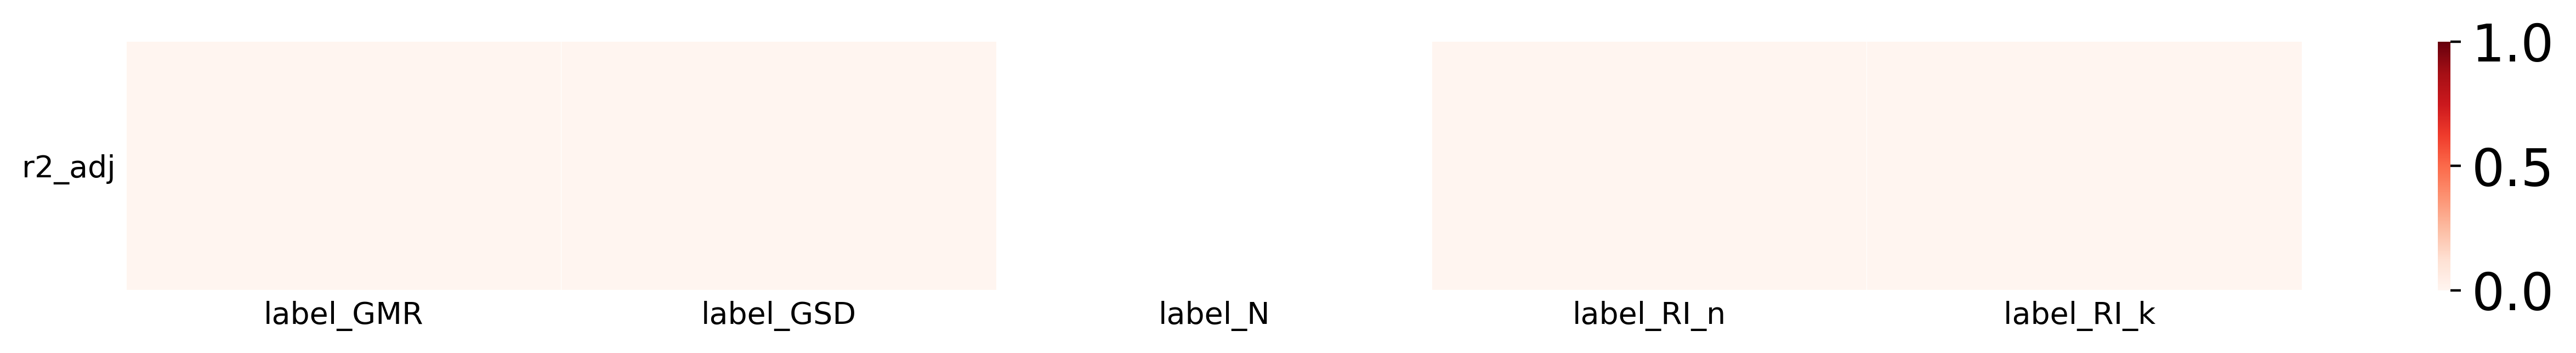

In [39]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_dvar1, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_dvar1.jpg')


In [40]:
r2_adj_T_dvar1

r2_adj
label_GMR     -0.00
label_GSD     -0.00
label_N        -inf
label_RI_n    -0.01
label_RI_k    -0.01

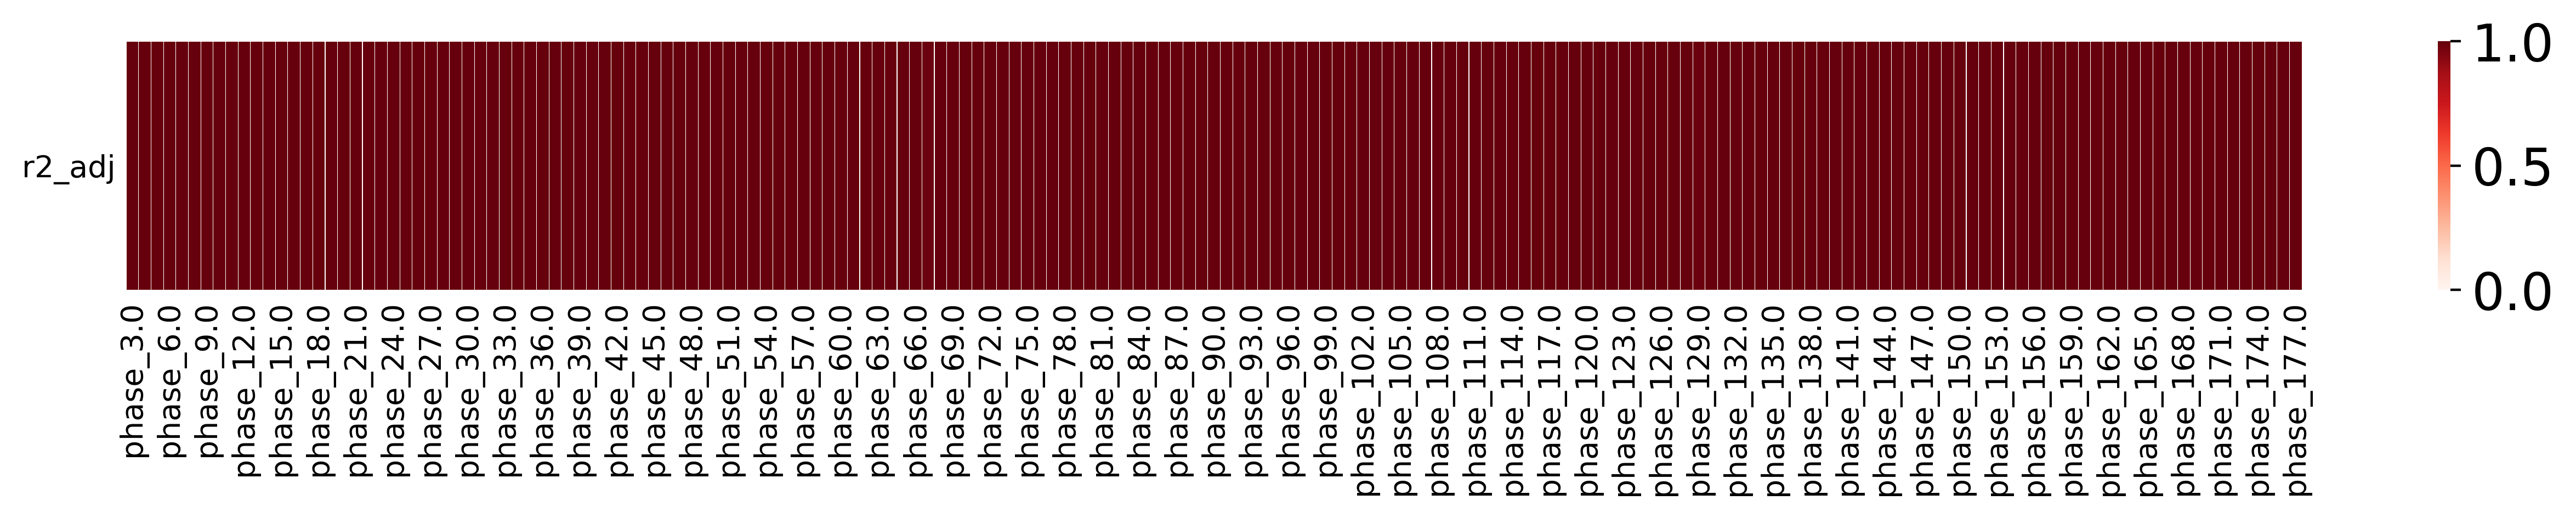

In [41]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_qoi.jpg')


## Relative Errors

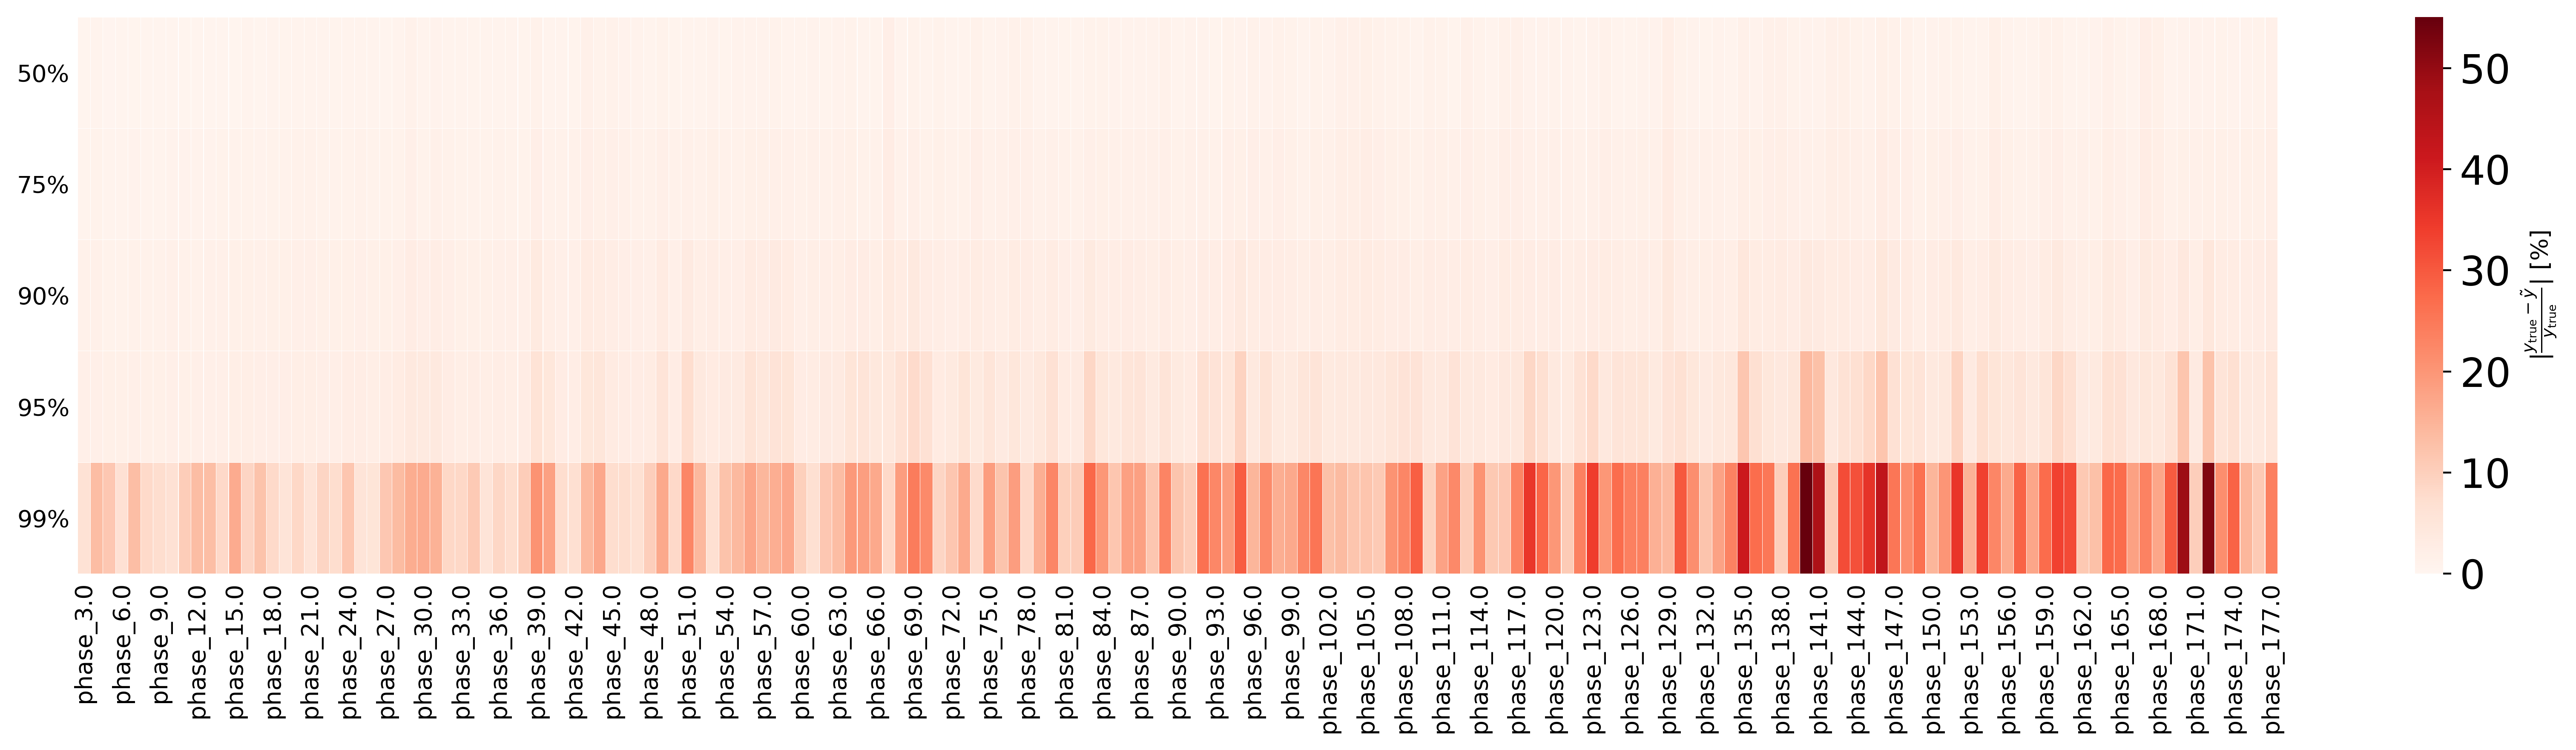

In [42]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_qoi.jpg')

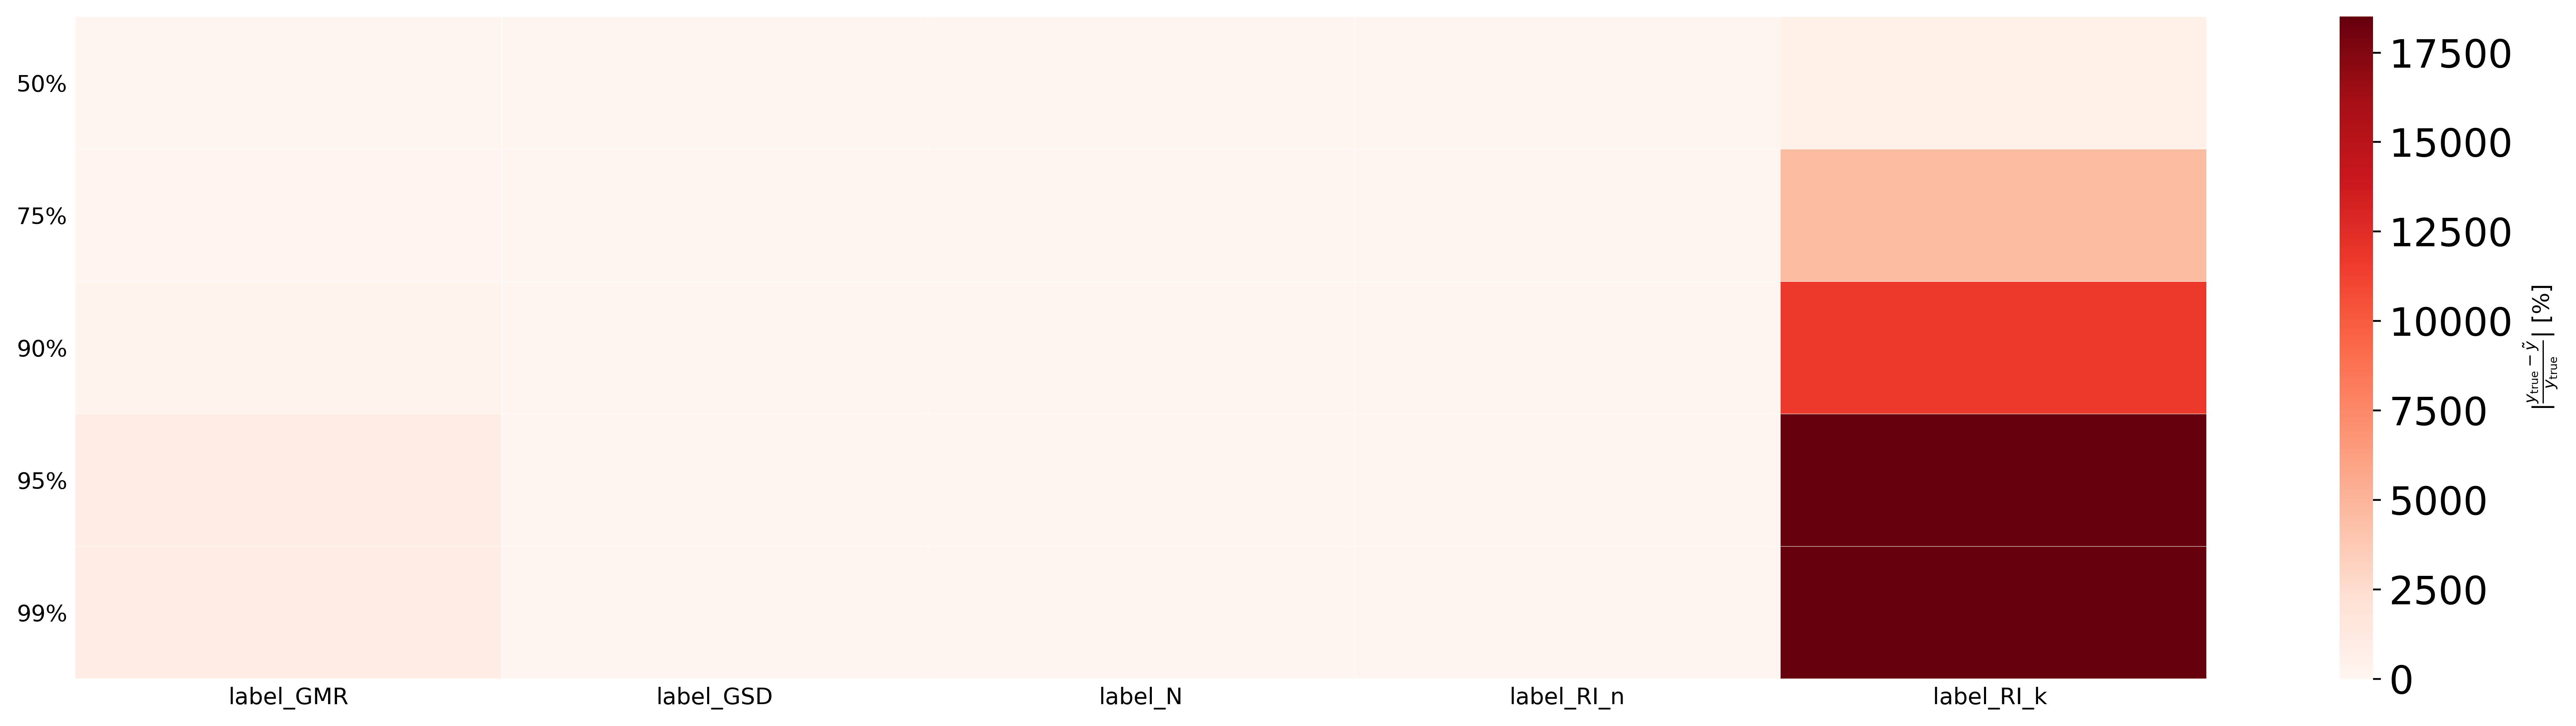

In [43]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_dvar1,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_dvar1.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_dvar1.jpg')

## Correlations between DVARs and QOIs

In [44]:
combined = pd.concat([dvar_test, rel_error_qoi], axis=1)

In [45]:
corr = np.round(combined.corr(), decimals=2)

In [46]:
to_plot = corr.copy()
to_plot.drop(columns=dvar.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [47]:
qoi.columns

Index(['phase_3.0', 'phase_4.0', 'phase_5.0', 'phase_6.0', 'phase_7.0',
       'phase_8.0', 'phase_9.0', 'phase_10.0', 'phase_11.0', 'phase_12.0',
       ...
       'phase_168.0', 'phase_169.0', 'phase_170.0', 'phase_171.0',
       'phase_172.0', 'phase_173.0', 'phase_174.0', 'phase_175.0',
       'phase_176.0', 'phase_177.0'],
      dtype='object', length=175)

In [48]:
to_plot = to_plot.drop(qoi.columns, axis =0)

In [49]:
to_plot

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
label_GMR        -0.17      -0.07      -0.06      -0.17      -0.08      -0.13   
label_GSD        -0.10      -0.06      -0.05      -0.10      -0.07      -0.11   
label_N            NaN        NaN        NaN        NaN        NaN        NaN   
label_RI_n       -0.04      -0.04      -0.03      -0.05      -0.04      -0.05   
label_RI_k        0.01      -0.01      -0.01       0.00      -0.01      -0.01   

             phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
label_GMR        -0.06       -0.14       -0.08       -0.09  ...        -0.14   
label_GSD        -0.05       -0.11       -0.07       -0.08  ...        -0.05   
label_N            NaN         NaN         NaN         NaN  ...          NaN   
label_RI_n       -0.04       -0.05       -0.04       -0.05  ...        -0.07   
label_RI_k       -0.00       -0.02       -0.01       -0.01  ...         0.05   

             phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
label_GMR          -0.07        -0.11        -0.27        -0.16        -0.08   
label_GSD          -0.01        -0.04        -0.08        -0.05        -0.03   
label_N              NaN          NaN          NaN          NaN          NaN   
label_RI_n         -0.04        -0.05        -0.06        -0.07        -0.05   
label_RI_k          0.02         0.04         0.09         0.05         0.03   

             phase_174.0  phase_175.0  phase_176.0  phase_177.0  
label_GMR          -0.15        -0.16        -0.04        -0.13  
label_GSD          -0.05        -0.05        -0.01        -0.06  
label_N              NaN          NaN          NaN          NaN  
label_RI_n         -0.07        -0.05        -0.03        -0.05  
label_RI_k          0.04         0.05         0.02         0.05  

[5 rows x 175 columns]

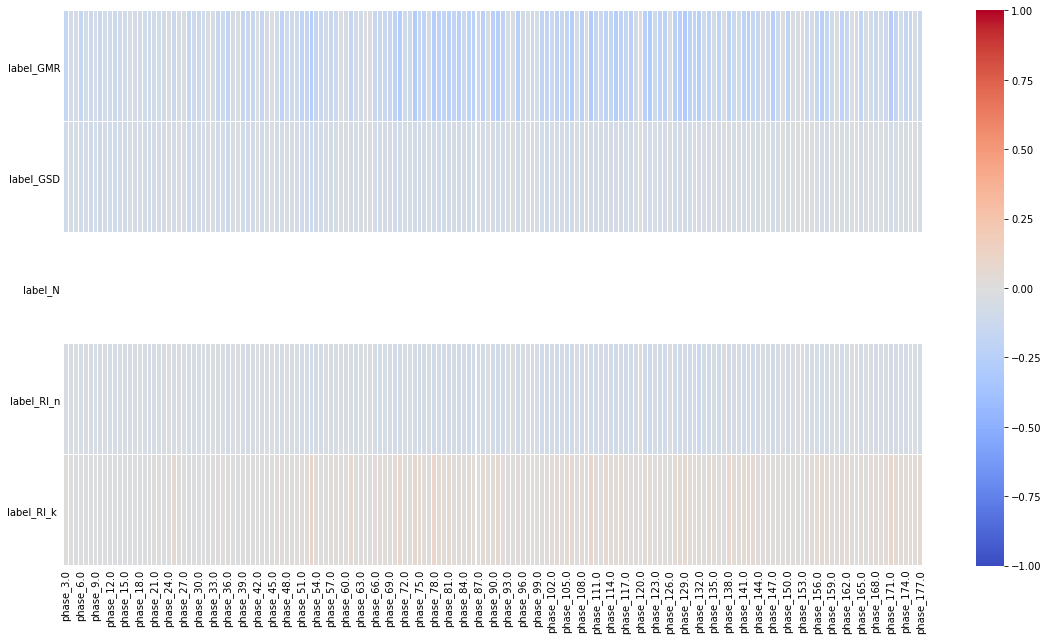

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [51]:
error_qoi = qoi_test - qoi_pred_test


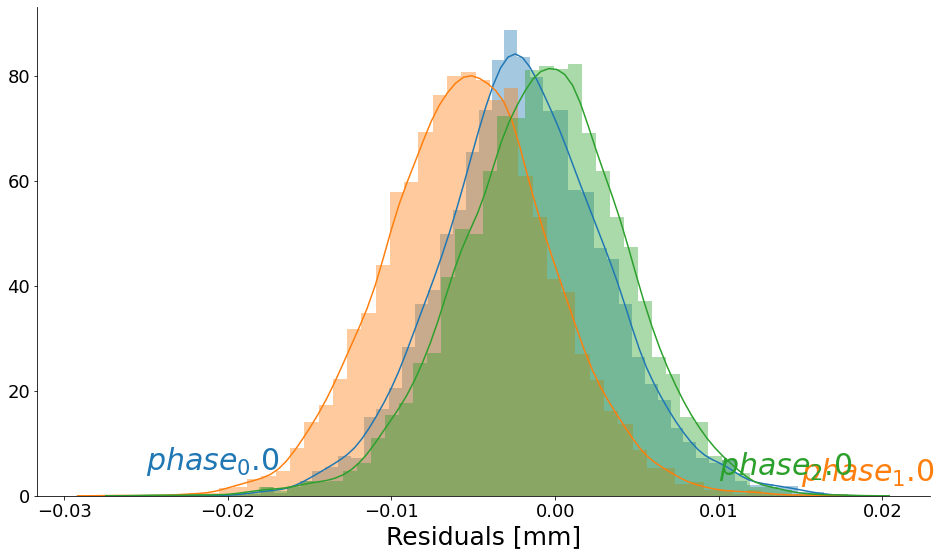

In [52]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in ['phase_3.0', 'phase_4.0', 'phase_5.0']:
    sns.distplot(error_qoi[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[0],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[1],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[2],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

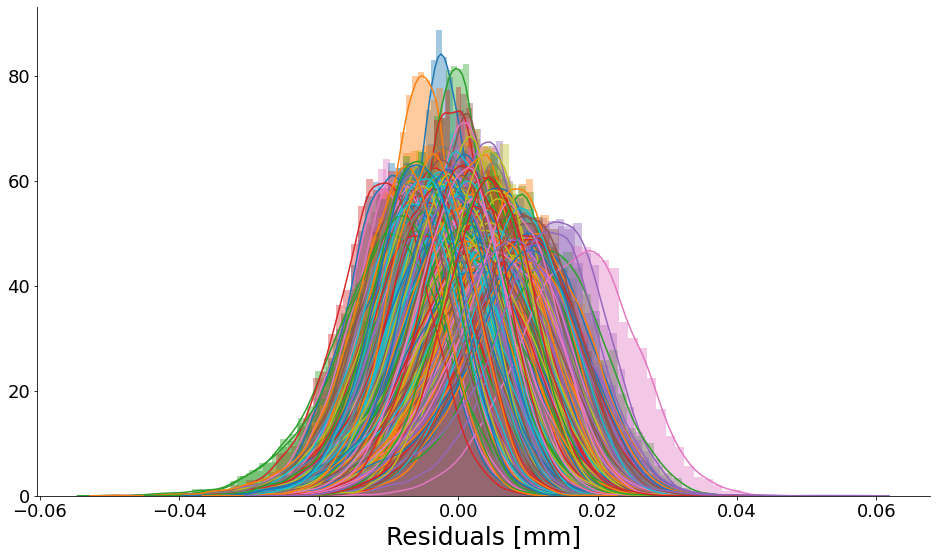

In [53]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error_qoi[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [54]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [55]:
for i, col in enumerate(qoi.columns[0:11]):
    print(i)
    print(col)

0
phase_3.0
1
phase_4.0
2
phase_5.0
3
phase_6.0
4
phase_7.0
5
phase_8.0
6
phase_9.0
7
phase_10.0
8
phase_11.0
9
phase_12.0
10
phase_13.0


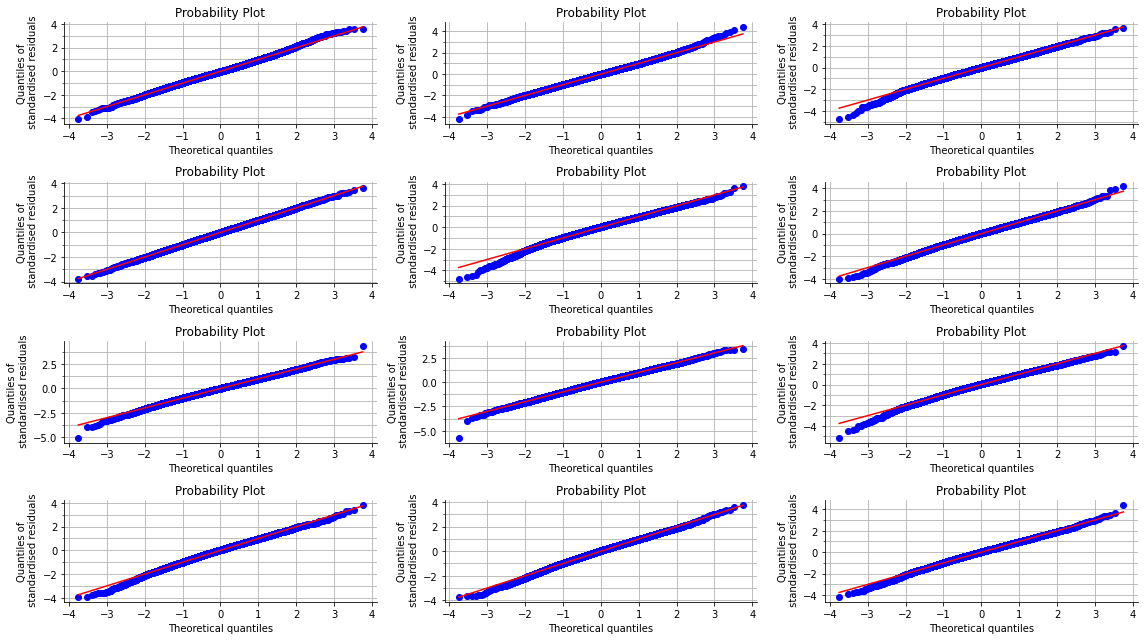

In [56]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error_qoi[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [57]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [58]:
rel_error_qoi.abs().quantile(0.9)

phase_3.0      1.332899
phase_4.0      1.575200
phase_5.0      1.174061
phase_6.0      1.257145
phase_7.0      1.455165
                 ...   
phase_173.0    3.152810
phase_174.0    3.186931
phase_175.0    2.786989
phase_176.0    2.833090
phase_177.0    3.462318
Name: 0.9, Length: 175, dtype: float64

In [59]:
statistic, p = scipy.stats.shapiro(standardise(error_qoi['phase_4.0']).values)

/psi/home/boiger_r/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [60]:
p

5.066595258540474e-05

In [61]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 175)               155050    
_________________________________________________________________
sequential_1 (Sequential)    (None, 5)                 616880    
Total params: 771,930
Trainable params: 771,930
Non-trainable params: 0
_________________________________________________________________


In [76]:

presentation_plot_index = [0,1,3,4,5,6,7,8,9]

qoi_test.index.values

array([   0,    1,    2, ..., 7917, 7918, 7919])

No handles with labels found to put in legend.


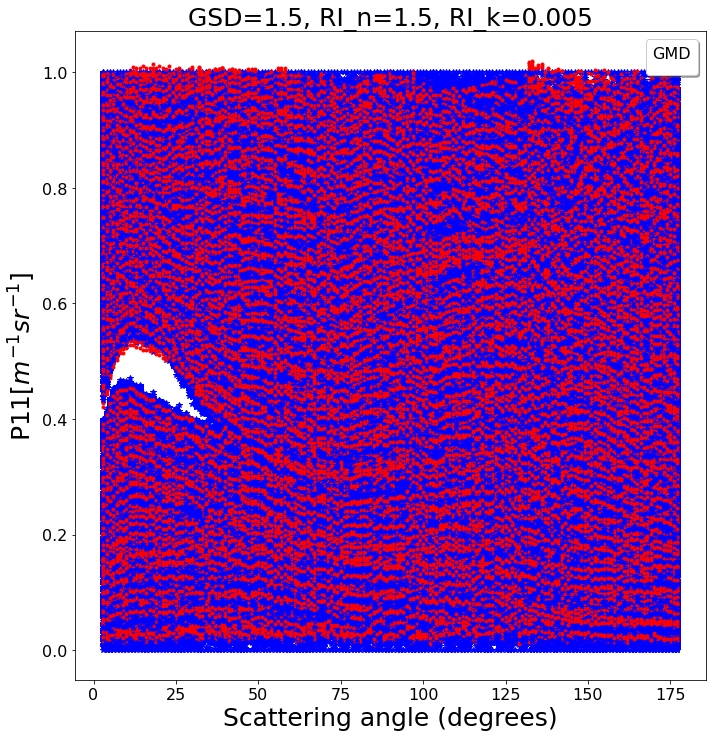

In [63]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    ax.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [64]:
qoi_test

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
0      0.293926   0.297136   0.317129   0.333955   0.336634   0.353476   
1      0.984087   0.964370   0.968301   0.958173   0.944903   0.926981   
2      0.969453   0.978541   0.979434   0.962703   0.935909   0.894409   
3      0.684786   0.706945   0.741713   0.756078   0.764045   0.761659   
4      0.901635   0.905837   0.910710   0.913708   0.893003   0.877166   
...         ...        ...        ...        ...        ...        ...   
7915   0.831362   0.855413   0.892699   0.920460   0.923582   0.907406   
7916   0.971374   0.954816   0.951292   0.942733   0.926668   0.909787   
7917   0.897350   0.895974   0.912012   0.918060   0.909722   0.887968   
7918   0.988132   0.979064   0.967328   0.969047   0.962531   0.959530   
7919   0.932393   0.926774   0.930928   0.924537   0.922314   0.918111   

      phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
0      0.348549    0.355034    0.358621    0.362453  ...     0.175332   
1      0.908924    0.890386    0.894533    0.887281  ...     0.738037   
2      0.848214    0.825768    0.828696    0.813637  ...     0.554552   
3      0.740557    0.740031    0.733136    0.719393  ...     0.310880   
4      0.853986    0.843659    0.817558    0.789864  ...     0.515433   
...         ...         ...         ...         ...  ...          ...   
7915   0.896261    0.873261    0.851062    0.835880  ...     0.791967   
7916   0.882958    0.865206    0.842255    0.832346  ...     0.561343   
7917   0.880768    0.861503    0.864392    0.855365  ...     0.739543   
7918   0.943958    0.936580    0.936281    0.932382  ...     0.962261   
7919   0.908292    0.885971    0.886959    0.876688  ...     0.890067   

      phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
0        0.168373     0.172540     0.179820     0.166861     0.182770   
1        0.747807     0.747131     0.771873     0.773737     0.784017   
2        0.544563     0.541726     0.552107     0.551219     0.538740   
3        0.292682     0.299052     0.304280     0.293339     0.293623   
4        0.510716     0.513221     0.515935     0.514908     0.520619   
...           ...          ...          ...          ...          ...   
7915     0.786923     0.784015     0.788820     0.770926     0.739588   
7916     0.554447     0.551159     0.567366     0.557136     0.554827   
7917     0.728886     0.735986     0.741995     0.747715     0.736486   
7918     0.967261     0.980953     0.985834     0.980373     0.971369   
7919     0.885660     0.900766     0.904667     0.902679     0.902657   

      phase_174.0  phase_175.0  phase_176.0  phase_177.0  
0        0.168288     0.171785     0.174967     0.173986  
1        0.780550     0.775808     0.763800     0.731453  
2        0.529636     0.536683     0.531944     0.519098  
3        0.289453     0.291274     0.288827     0.286879  
4        0.521044     0.508619     0.517929     0.522853  
...           ...          ...          ...          ...  
7915     0.725546     0.718074     0.705391     0.709023  
7916     0.546130     0.556069     0.551506     0.543083  
7917     0.739947     0.736188     0.713812     0.698832  
7918     0.964358     0.976770     0.968647     0.958421  
7919     0.898572     0.888997     0.892124     0.866431  

[7920 rows x 175 columns]

In [65]:
qoi_pred_test

phase_3.0  phase_4.0  phase_5.0  phase_6.0  phase_7.0  phase_8.0  \
0      0.292523   0.307316   0.326138   0.338951   0.347374   0.355101   
1      0.980211   0.973051   0.964770   0.958097   0.936691   0.926293   
2      0.968222   0.978094   0.975600   0.959867   0.923485   0.892379   
3      0.692672   0.715897   0.740198   0.757703   0.759688   0.760757   
4      0.910266   0.911541   0.912639   0.911857   0.894403   0.877754   
...         ...        ...        ...        ...        ...        ...   
7915   0.829997   0.864291   0.894128   0.916083   0.915110   0.908284   
7916   0.966480   0.960065   0.952489   0.944517   0.921516   0.905814   
7917   0.899639   0.909038   0.916285   0.921258   0.908507   0.898370   
7918   0.993768   0.983710   0.975909   0.973631   0.960001   0.955117   
7919   0.933949   0.933290   0.933776   0.935625   0.922348   0.914796   

      phase_9.0  phase_10.0  phase_11.0  phase_12.0  ...  phase_168.0  \
0      0.353864    0.356981    0.362641    0.361206  ...     0.171097   
1      0.911179    0.902420    0.895949    0.887876  ...     0.727694   
2      0.858537    0.842605    0.831059    0.814990  ...     0.534744   
3      0.751202    0.740359    0.732592    0.719517  ...     0.296727   
4      0.856225    0.834998    0.818002    0.797914  ...     0.509489   
...         ...         ...         ...         ...  ...          ...   
7915   0.892970    0.869692    0.849104    0.830133  ...     0.776192   
7916   0.883201    0.864912    0.851446    0.831029  ...     0.551704   
7917   0.882627    0.870217    0.863530    0.857932  ...     0.714700   
7918   0.945353    0.938207    0.933720    0.933090  ...     0.955931   
7919   0.900644    0.891210    0.883680    0.877418  ...     0.870290   

      phase_169.0  phase_170.0  phase_171.0  phase_172.0  phase_173.0  \
0        0.173180     0.180660     0.182239     0.183993     0.181940   
1        0.739033     0.754869     0.765898     0.780263     0.788740   
2        0.539240     0.544764     0.544713     0.546182     0.542206   
3        0.298295     0.303216     0.303639     0.304427     0.299635   
4        0.513635     0.520662     0.521434     0.523084     0.520884   
...           ...          ...          ...          ...          ...   
7915     0.780694     0.783750     0.777692     0.767642     0.752922   
7916     0.556492     0.562948     0.563173     0.564449     0.560082   
7917     0.726686     0.739743     0.744556     0.749039     0.747800   
7918     0.966551     0.974109     0.976325     0.980865     0.982525   
7919     0.881419     0.892651     0.896574     0.901277     0.904185   

      phase_174.0  phase_175.0  phase_176.0  phase_177.0  
0        0.183463     0.183707     0.180417     0.179216  
1        0.786681     0.781019     0.762599     0.728871  
2        0.535017     0.526984     0.518063     0.505729  
3        0.297014     0.294126     0.288708     0.282968  
4        0.514902     0.511996     0.507386     0.500567  
...           ...          ...          ...          ...  
7915     0.731395     0.717995     0.707869     0.702303  
7916     0.552351     0.546545     0.539238     0.527950  
7917     0.738026     0.729194     0.715824     0.697939  
7918     0.974573     0.976039     0.965603     0.945745  
7919     0.895003     0.891315     0.878155     0.856689  

[7920 rows x 175 columns]

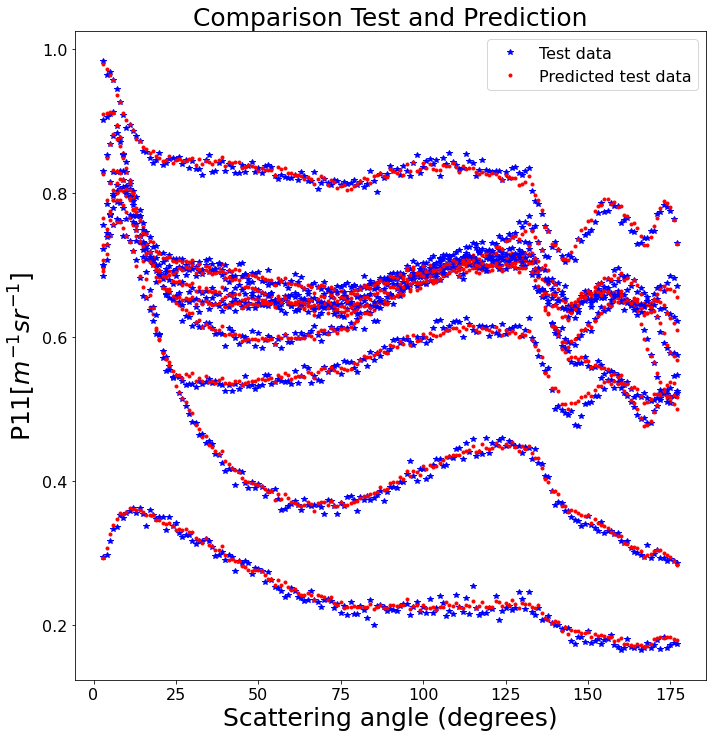

In [77]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

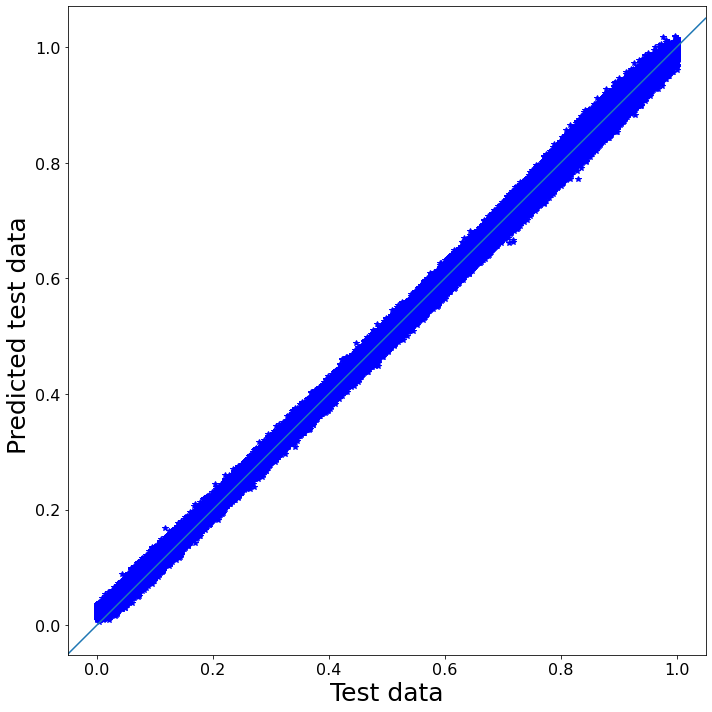

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([0, 0], [1, 1])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [68]:
model_dir

'/data/user/boiger_r/aerosol/aerosol_results/models_phase/autoencoder/autoencoder_noise_small0'

In [69]:
history_file = model_dir+'/history_loss.csv'
history = pd.read_csv(history_file)
history


loss  val_loss
0   4.319828  3.443648
1   3.459008  3.432780
2   3.434973  3.418271
3   3.378953  3.298864
4   3.283502  3.193525
..       ...       ...
95  3.146118  3.138662
96  3.145565  3.133857
97  3.146404  3.130607
98  3.146739  3.132595
99  3.145937  3.131244

[100 rows x 2 columns]

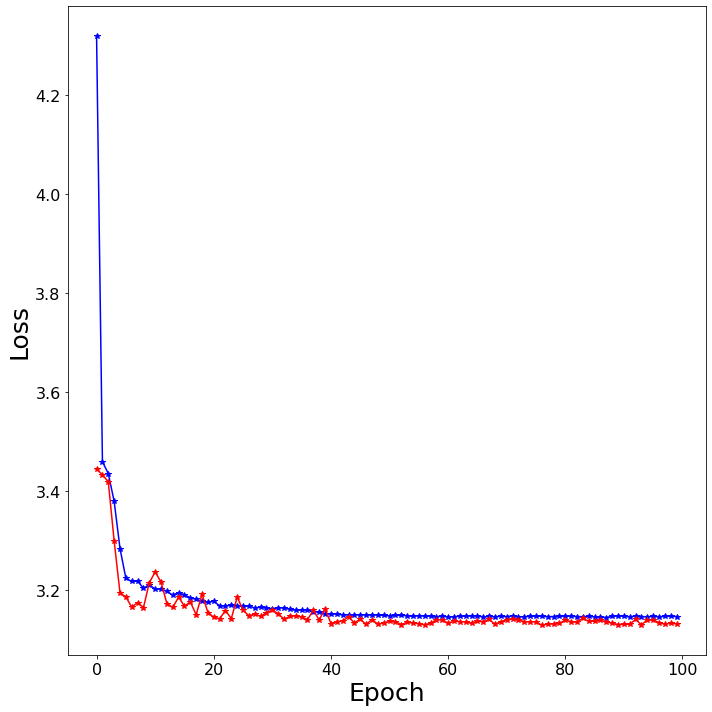

In [70]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
ax.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
ax.set_xlabel('Epoch',fontsize = 25)
ax.set_ylabel('Loss',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

fig.savefig(f'{plot_dir}/Loss_over_epoch.jpg')


In [71]:
from keras.utils.vis_utils import plot_model

In [72]:
plot_dir

'/data/user/boiger_r/aerosol/aerosol_results/models_phase/autoencoder/autoencoder_noise_small0/plots/model'

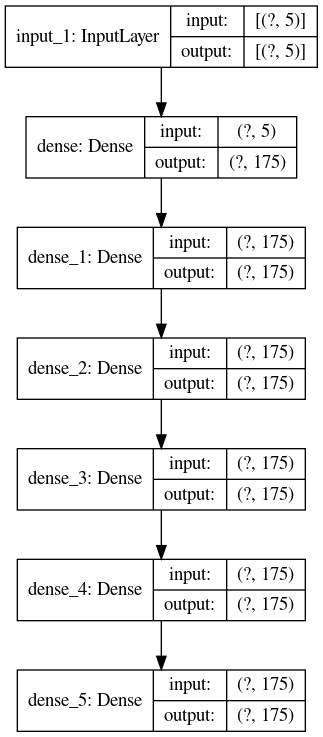

In [73]:
plot_model(autoencoder.encoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


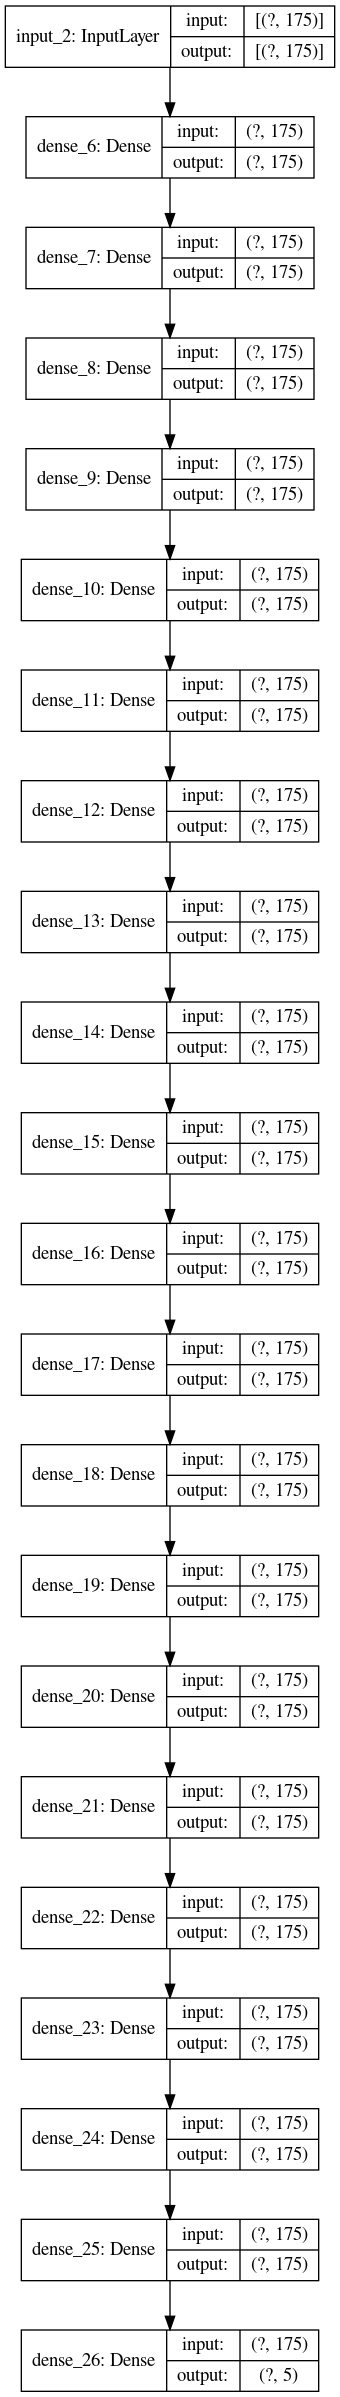

In [74]:
plot_model(autoencoder.decoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


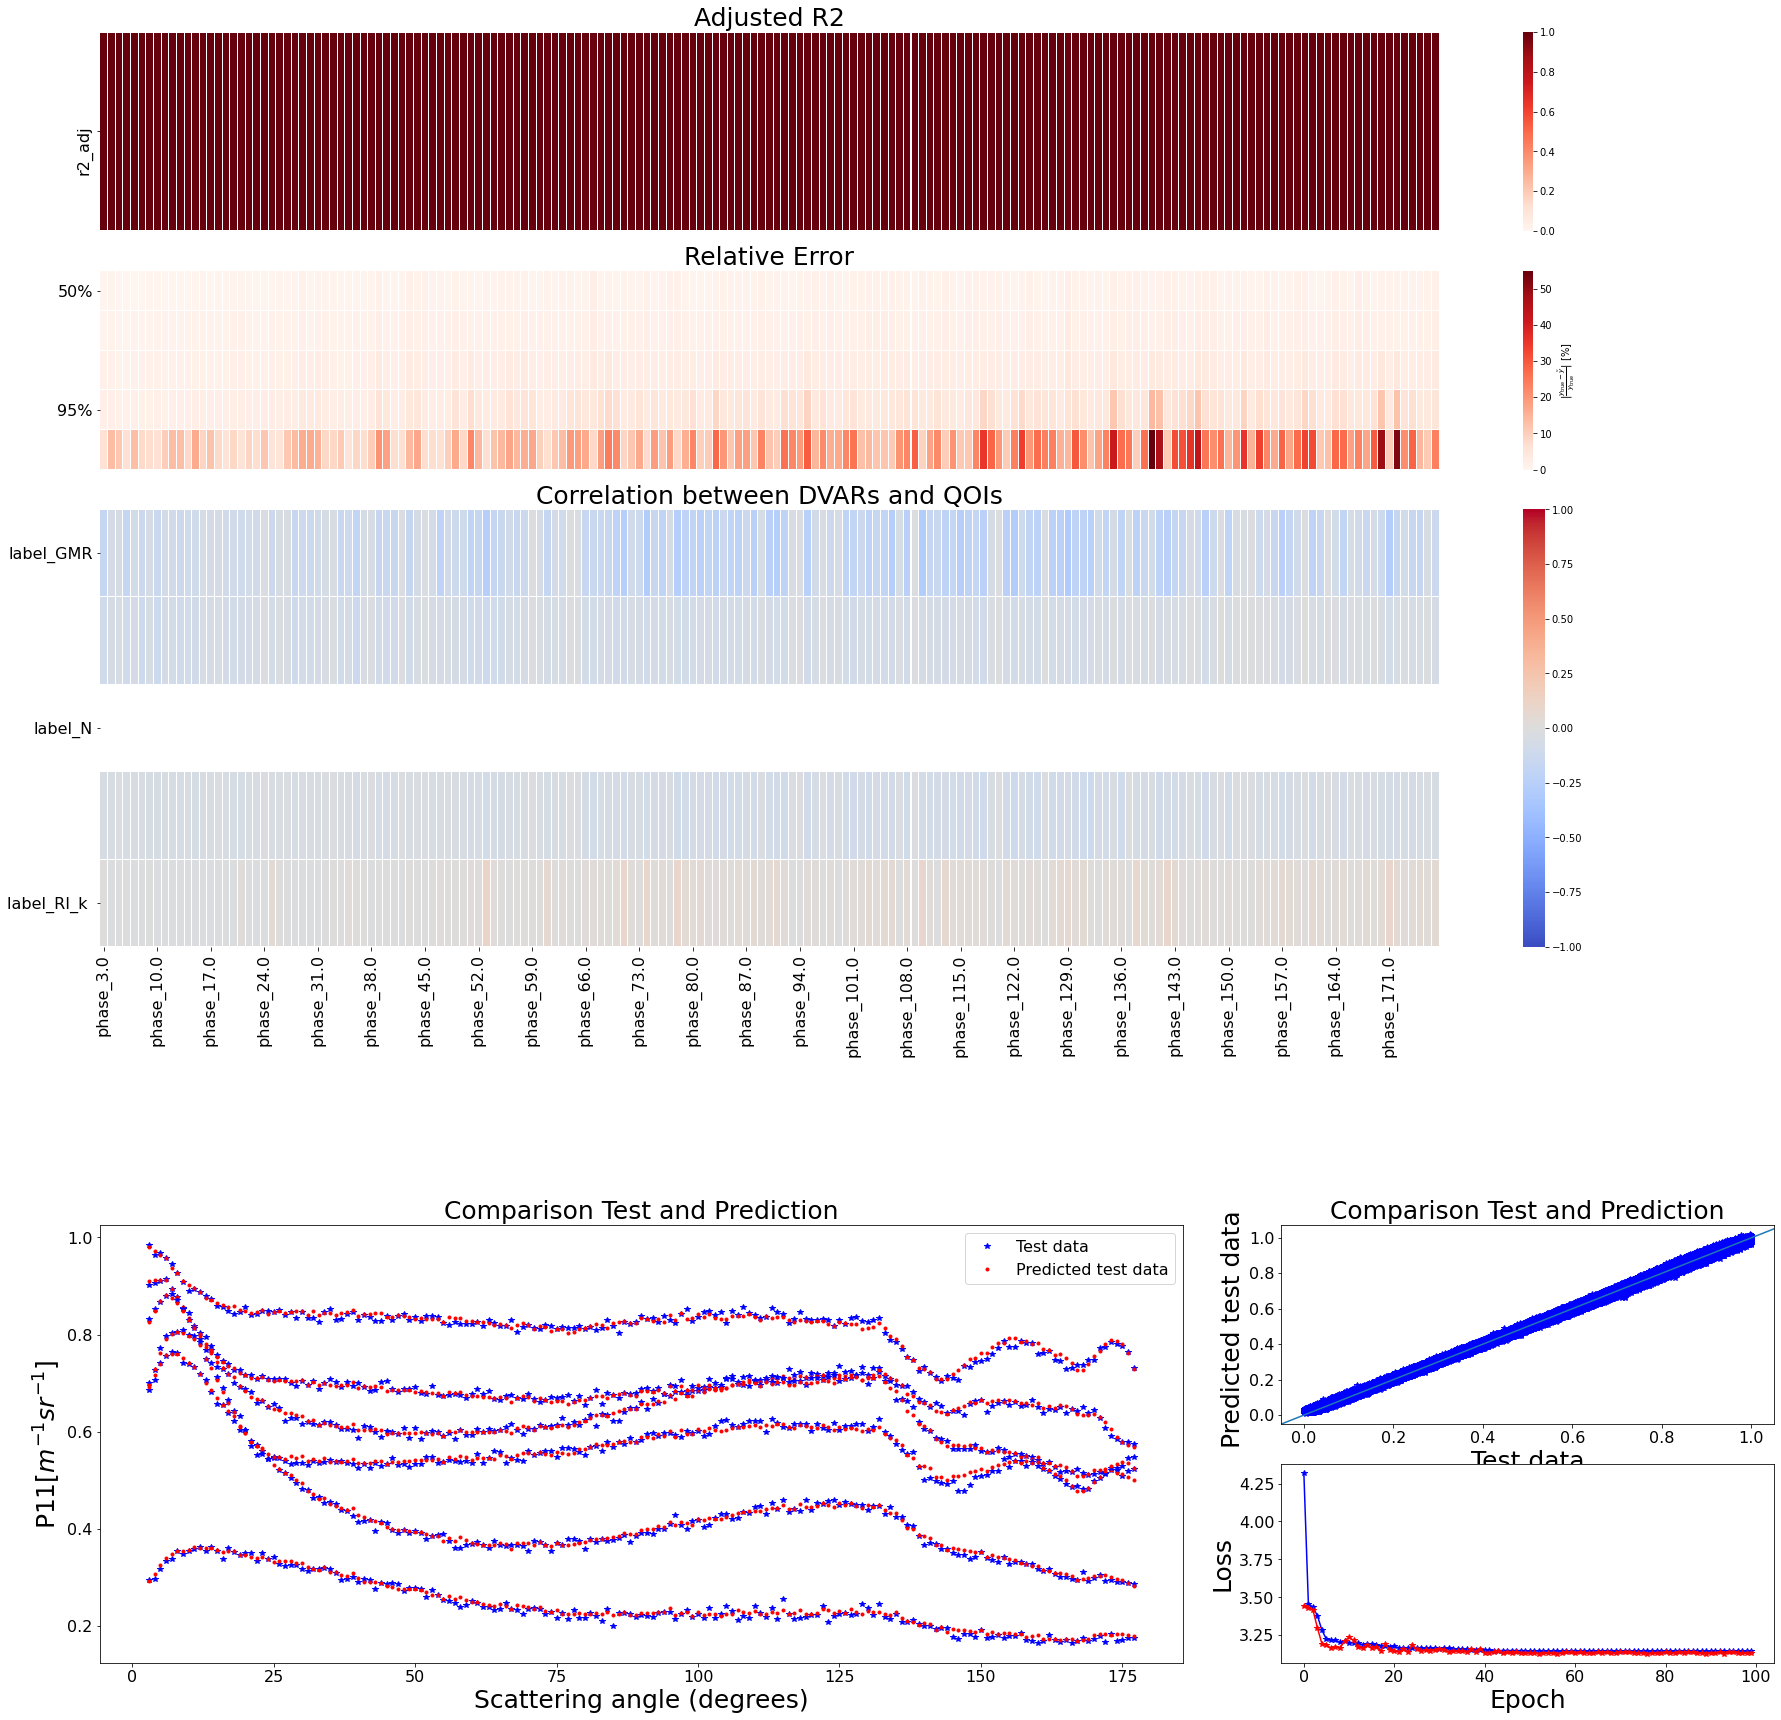

In [75]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([0, 0], [1,1])

plt.subplot2grid((7,3), (6,2), colspan=1, rowspan=1)

plt.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
plt.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
plt.xlabel('Epoch',fontsize = 25)
plt.ylabel('Loss',fontsize = 25)
plt.tick_params(labelsize = 16)    


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_autoencoder_model.jpg')
